### 1. Load and Preprocess the MNIST Dataset

In [8]:
# Loading packages
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data
from torchvision import datasets, transforms

# Define transformations for the MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

# Load the MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = data.DataLoader(test_dataset, batch_size=1000, shuffle=False)


### 2. Define a Simple Neural Network Model

In [11]:
class ModelNN(nn.Module):
    def __init__(self):
        super(ModelNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 300)
        self.fc2 = nn.Linear(300, 100)
        self.fc3 = nn.Linear(100, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

model = ModelNN()


### 3. Train the Model to Establish a Baseline Accuracy

In [12]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, accuracy

# Set device, optimizer, and train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Training loop
for epoch in range(1, 6):
    train(model, device, train_loader, optimizer, epoch)

# Evaluate the baseline model
baseline_loss, baseline_accuracy = test(model, device, test_loader)
print(f"Baseline Accuracy: {baseline_accuracy:.2f}%")


Baseline Accuracy: 97.90%


### 4. Apply Pruning to the Model

In [13]:
import torch.nn.utils.prune as prune

# Pruning parameters
parameters_to_prune = (
    (model.fc1, 'weight'),
    (model.fc2, 'weight'),
)

# Apply pruning to the model
prune.global_unstructured(
    parameters_to_prune,
    pruning_method=prune.L1Unstructured,
    amount=0.5,  
)

### 5. Retrain the Pruned Model

In [14]:
# Retrain the pruned model
for epoch in range(1, 6):
    train(model, device, train_loader, optimizer, epoch)

# Evaluate the pruned model
pruned_loss, pruned_accuracy = test(model, device, test_loader)
print(f"Pruned Model Accuracy: {pruned_accuracy:.2f}%")


Pruned Model Accuracy: 98.23%


### 6. Compare Performance and Plot Results

/var/folders/ln/h2wkl_x92m56lbsz9fzn33l00000gn/T/ipykernel_88334/2649122568.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


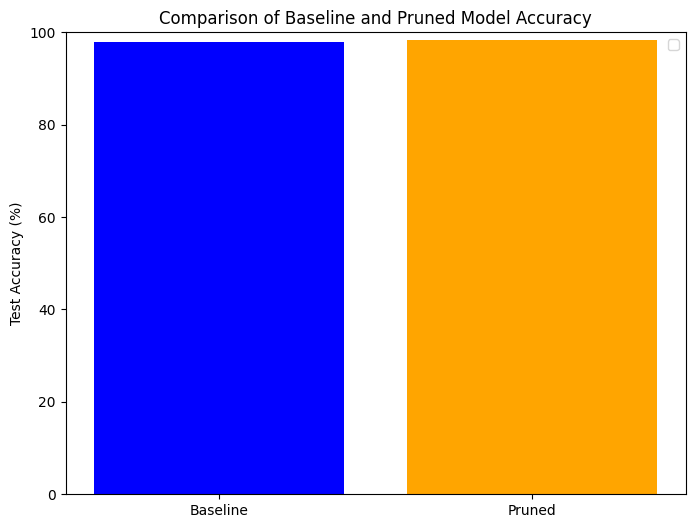

In [16]:
import matplotlib.pyplot as plt

# Plot the results
labels = ['Baseline', 'Pruned']
accuracies = [baseline_accuracy, pruned_accuracy]

plt.figure(figsize=(8, 6))
plt.bar(labels, accuracies, color=['blue', 'orange'])
plt.ylabel('Test Accuracy (%)')
plt.title('Comparison of Baseline and Pruned Model Accuracy')
plt.ylim(0, 100)
plt.legend()
plt.show()